In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [8]:
import optuna
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def get_data_loaders(batch_size):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/"
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_dataset, test_transform

In [13]:
def inverse_normalize(img_tensor, mean=[0.5]*3, std=[0.5]*3):
    inv = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    return inv(img_tensor)


def visualize_augmented_vs_original(train_dataset, test_transform, n_images=6):
    raw_dataset = datasets.ImageFolder(train_dataset.root, transform=test_transform)
    raw_loader = DataLoader(raw_dataset, batch_size=n_images, shuffle=True)
    aug_loader = DataLoader(train_dataset, batch_size=n_images, shuffle=True)

    raw_imgs, _ = next(iter(raw_loader))
    aug_imgs, _ = next(iter(aug_loader))

    raw_imgs = torch.stack([inverse_normalize(img) for img in raw_imgs])
    aug_imgs = torch.stack([inverse_normalize(img) for img in aug_imgs])

    def show_grid(images, title):
        grid = torchvision.utils.make_grid(images, nrow=n_images)
        npimg = grid.numpy().transpose((1, 2, 0))
        plt.figure(figsize=(12, 3))
        plt.imshow(np.clip(npimg, 0, 1))
        plt.axis('off')
        plt.title(title)
        plt.show()

    show_grid(raw_imgs, "Original Images")
    show_grid(aug_imgs, "Augmented Images")

def plot_class_distribution(train_dataset):
    class_names = train_dataset.classes
    class_counts = [0] * len(class_names)
    for _, label in train_dataset.samples:
        class_counts[label] += 1

    df = pd.DataFrame({
        "Class": class_names,
        "Count": class_counts
    })

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x="Class", y="Count")
    plt.title("Training Set Class Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

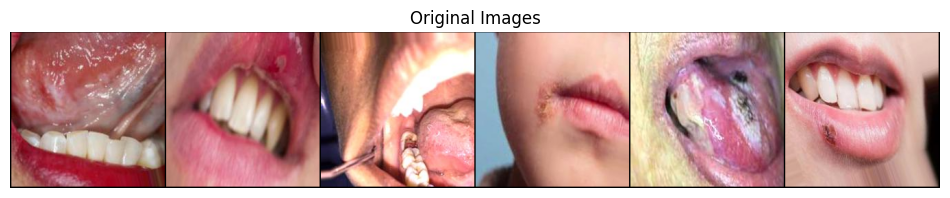

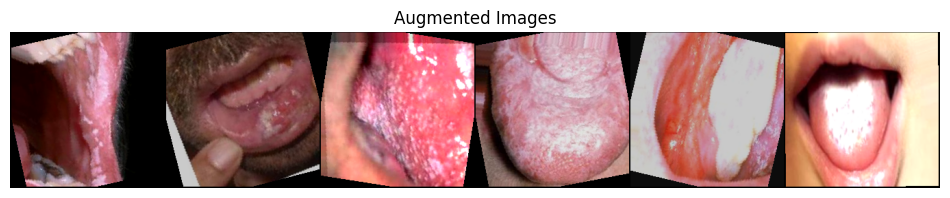

In [14]:
batch_size = 16
train_loader, val_loader, train_dataset, test_transform = get_data_loaders(batch_size)

visualize_augmented_vs_original(train_dataset, test_transform)

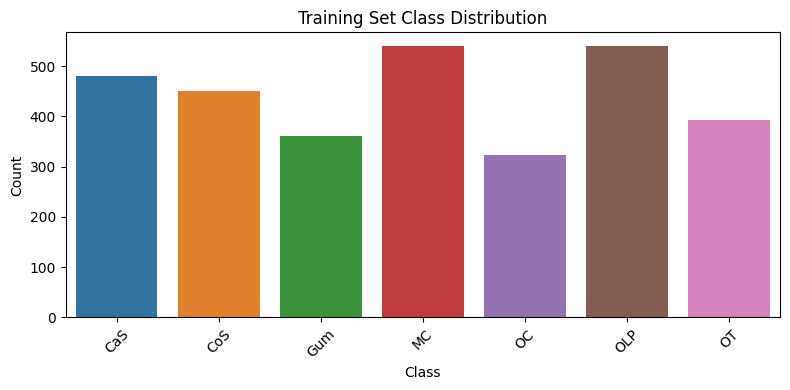

In [18]:
# Plot class counts
import seaborn as sns
plot_class_distribution(train_dataset)

In [23]:
def define_model(trial, num_classes):
    # Hyperparameter suggestions
    conv1_out = trial.suggest_int("conv1_out", 16, 64, step=16)
    conv2_out = trial.suggest_int("conv2_out", 32, 128, step=32)
    fc_size = trial.suggest_int("fc_size",64, 1028, step= 64)
    kernel_size = 3  # fixed based on earlier insight
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6)

    class TunedCNN(nn.Module):
        def __init__(self):
            super(TunedCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=kernel_size, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=kernel_size, padding=1)

            # Dynamically compute the flatten size
            with torch.no_grad():
                dummy_input = torch.zeros(1, 3, 224, 224)  # match input image size
                out = self.pool(F.relu(self.conv1(dummy_input)))
                out = self.pool(F.relu(self.conv2(out)))
                flatten_dim = out.view(1, -1).size(1)

            self.fc1 = nn.Linear(flatten_dim, fc_size)
            self.fc2 = nn.Linear(fc_size, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    return TunedCNN()

In [21]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    train_loader, val_loader, train_dataset, test_transform = get_data_loaders(batch_size)
    num_classes = len(train_dataset.classes)
    model = define_model(trial, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(3):  # just 3 epochs for speed
        for images, labels in tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-07-02 14:46:13,271] A new study created in memory with name: no-name-30985a2a-0002-42fc-b824-d9013979b24e
/tmp/ipykernel_35/4177252045.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [64, 1028] and step=64, but the range is not divisible by `step`. It will be replaced by [64, 1024].
  warnings.warn(
[I 2025-07-02 14:47:41,043] Trial 0 finished with value: 0.3229571984435798 and parameters: {'batch_size': 16, 'lr': 0.0029829126045651097, 'optimizer': 'SGD', 'conv1_out': 48, 'conv2_out': 32, 'fc_size': 1024, 'dropout': 0.5656357717384404}. Best is trial 0 with value: 0.3229571984435798.
[I 2025-07-02 14:48:40,034] Trial 1 finished with value: 0.49

Best trial:
  Accuracy: 0.5505836575875487
  Params:
    batch_size: 16
    lr: 0.0004259189730230001
    optimizer: Adam
    conv1_out: 16
    conv2_out: 128
    fc_size: 256
    dropout: 0.40636130138026194


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BestTeethCNN(nn.Module):
    def __init__(self, num_classes, dropout=0.40636130138026194):
        super(BestTeethCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, kernel_size=3, padding=1)

        # Compute flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            self.flattened_size = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [27]:
train_loader, val_loader, train_dataset, test_transform = get_data_loaders(16)
num_classes = len(train_dataset.classes)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BestTeethCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004259189730230001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")


Epoch [1/30], Loss: 408.8315, Accuracy: 0.2222
Epoch [2/30], Loss: 335.8525, Accuracy: 0.3139
Epoch [3/30], Loss: 312.4944, Accuracy: 0.3761
Epoch [4/30], Loss: 286.8363, Accuracy: 0.4270
Epoch [5/30], Loss: 269.7721, Accuracy: 0.4616
Epoch [6/30], Loss: 252.1645, Accuracy: 0.5086
Epoch [7/30], Loss: 231.6319, Accuracy: 0.5494
Epoch [8/30], Loss: 230.5320, Accuracy: 0.5649
Epoch [9/30], Loss: 211.8542, Accuracy: 0.5873
Epoch [10/30], Loss: 203.9057, Accuracy: 0.5986
Epoch [11/30], Loss: 201.9340, Accuracy: 0.6223
Epoch [12/30], Loss: 191.1693, Accuracy: 0.6349
Epoch [13/30], Loss: 181.7828, Accuracy: 0.6547
Epoch [14/30], Loss: 177.3341, Accuracy: 0.6650
Epoch [15/30], Loss: 169.5962, Accuracy: 0.6796
Epoch [16/30], Loss: 163.0863, Accuracy: 0.7013
Epoch [17/30], Loss: 155.7686, Accuracy: 0.7059
Epoch [18/30], Loss: 150.9896, Accuracy: 0.7149
Epoch [19/30], Loss: 149.0119, Accuracy: 0.7143
Epoch [20/30], Loss: 142.3903, Accuracy: 0.7383
Epoch [21/30], Loss: 134.0751, Accuracy: 0.7464
E

In [29]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.8502


In [33]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/"
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [35]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f"test Accuracy: {val_acc:.4f}")


test Accuracy: 0.5663
